In [300]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

## Utility functions

In [301]:
# use haversine formula to calculate shortest distance over the earth's surface
# https://en.wikipedia.org/wiki/Haversine_formula

def latlong_distance(lat1, long1, lat2, long2):
    lat1 = np.radians(lat1)
    lat2 = np.radians(lat2)
    lat_delta = lat2 - lat1
    long_delta = np.radians(long2 - long1)
    #a = sin^2(latitude delta / 2) + cos latitude 1 * cos latitude 2
    #* sin^2(longitude delta / 2)
    a = np.sin(lat_delta / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(long_delta / 2) ** 2

    #c = 2 * arcsin(a^0.5)
    c = 2 * np.arcsin(np.sqrt(a))
    
    #d = R * c
    R = 6371 #earth's radius = 6371km
    d = R * c
    return d

In [302]:
def closest_n_search(latlong, latlongs, **kwargs):
    # find n closest latlongs to the given coordinates and corresponding weights
    # input = tuple of target coordinates, list of tuples [(lat, long)], n
    # output = dict, key = weights, values = tuple(lat, long)
    target_lat, target_long = latlong
    min_latlong = tuple()
    min_distance = float('inf')
    dist = {}
    
    # evaluate each lat long pairs
    for (lat, long) in latlongs:
        # only evaluate lat long coordinates within a certain range
        if np.abs(lat - target_lat) <= 10 and np.abs(long - target_long) <= 10:
            dist = latlong_distance(target_lat, target_long, lat, long)

            if len(min_latlong) < 1 or dist <= min_distance:
                min_latlong = (lat, long)
                min_distance = dist
    return min_latlong, min_distance

## Pre-calculate closest n neighbors and corresponding weights of all coordinates

In [303]:
# read data file
#full.h5
file_loc = 'weather.h5'
df = pd.read_hdf(file_loc)
df.head(10)

,Date,Time,ForecastRange,x,y,lat,lng,5_Wave_Geopotential_Height_isobaric,Absolute_vorticity_isobaric,Apparent_temperature_height_above_ground,...,Ice_water_mixing_ratio_hybrid,Ice_water_mixing_ratio_isobaric,Precipitation_rate_surface,Rain_mixing_ratio_hybrid,Rain_mixing_ratio_isobaric,Snow_mixing_ratio_hybrid,Snow_mixing_ratio_isobaric,Total_cloud_cover_isobaric,Vertical_velocity_geometric_isobaric,Ice_growth_rate_altitude_above_msl
0,20170626,12,0,474,89,45.5,-123.0,5873.937988,0.000094,285.100006,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20170626,12,0,475,85,47.5,-122.5,5864.678223,0.000103,286.299988,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20170626,12,0,475,86,47.0,-122.5,5867.498047,0.000105,285.700012,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,20170626,12,0,476,86,47.0,-122.0,5867.658203,0.000103,284.200012,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20170626,12,0,477,103,38.5,-121.5,5876.218262,0.000072,286.200012,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,20170626,12,0,477,104,38.0,-121.5,5875.198242,0.000082,285.700012,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,20170626,12,0,477,105,37.5,-121.5,5874.078125,0.000085,285.399994,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,20170626,12,0,478,105,37.5,-121.0,5873.778320,0.000082,289.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,20170626,12,0,480,101,39.5,-120.0,5876.877930,0.000086,284.500000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,20170626,12,0,481,101,39.5,-119.5,5876.357910,0.000085,290.899994,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [304]:
# Select unique lat long combinations from the data
latlongs = df[['lat', 'lng']].values
latlongs = [(ll[0], ll[1]) for ll in latlongs]
latlongs = list(set(latlongs))
len(latlongs)

70

In [305]:
latlong_matches = {}
for i in range(len(latlongs)):
    latlong_match = closest_n_search(latlongs[i], latlongs[:i] + latlongs[i + 1:])
    latlong_matches[latlongs[i]] = latlong_match
    # return dict
    # key = (target_lat, target_long), value = (n_lat, n_long, dist)
        
"example of coordinates at a similar distance to multiple points, target point :(36.0, -86.5), closest neighbor:",\
latlong_matches[(36.0, -86.5)]

('example of coordinates at a similar distance to multiple points, target point :(36.0, -86.5), closest neighbor:',
 ((35.5, -85.0), 146.33500830642504))

Average distance with geo-imputing ref (km): 102.13665883307964
Min. distance with geo-imputing ref (km): 37.91731445505778
Max. distance with geo-imputing ref (km): 864.7121168931913


('Distribution of distance to closest neighbor (km)',
 (array([49., 13.,  5.,  2.,  0.,  0.,  0.,  0.]),
  array([  0, 100, 200, 300, 400, 500, 600, 700, 800]),
  <a list of 8 Patch objects>))

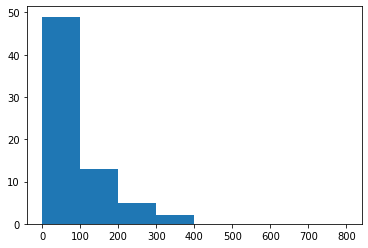

In [306]:
dist_closest_n = [i[1] for i in list(latlong_matches.values())]

print(f"Average distance with geo-imputing ref (km): {np.mean(dist_closest_n)}")
print(f"Min. distance with geo-imputing ref (km): {np.min(dist_closest_n)}")
print(f"Max. distance with geo-imputing ref (km): {np.max(dist_closest_n)}")

"Distribution of distance to closest neighbor (km)", plt.hist(dist_closest_n, bins=[0,100,200,300,400,500,600,700,800])

Some caveats to this method:
- Reliability of imputed results varies between points

## Clean data

**Columns to drop**:

["Categorical_Snow_surface",
"Composite_reflectivity_entire_atmosphere",
"Graupel_snow_pellets_hybrid",
"Graupel_snow_pellets_isobaric",
"Snow_mixing_ratio_hybrid",
"Snow_mixing_ratio_isobaric"
'Geopotential_height_potential_vorticity_surface',
'u_component_of_wind_potential_vorticity_surface',
'v_component_of_wind_potential_vorticity_surface',
'Categorical_Ice_Pellets_surface',
'Ice_water_mixing_ratio_hybrid',
'Ice_water_mixing_ratio_isobaric',
'Precipitation_rate_surface',
'Vertical_velocity_geometric_isobaric',
'Ice_growth_rate_altitude_above_msl',
'Land_sea_coverage_nearest_neighbor_land1sea0_surface',
'Pressure_potential_vorticity_surface',
'Temperature_potential_vorticity_surface',
'Vertical_Speed_Shear_potential_vorticity_surface',
'Rain_mixing_ratio_hybrid',
'Total_cloud_cover_isobaric',
'Cloud_mixing_ratio_hybrid',
'Categorical_Freezing_Rain_surface',
'Categorical_Rain_surface',
'Visibility_surface']

**Spatial Inputation**:

[Snow_depth_surface,
'Haines_Index_surface',
'u_component_of_wind_altitude_above_msl',
'v_component_of_wind_altitude_above_msl',
'Soil_temperature_depth_below_surface_layer',
'Temperature_altitude_above_msl'
'Volumetric_Soil_Moisture_Content_depth_below_surface_layer']

In [307]:
data = pd.read_hdf('data.h5')

119 features excluding date, lat, long, impact_score, etc.

### Drop columns with > 80% missing data

94 features excluding date, lat, long, impact_score, etc.

In [308]:
data = data.drop(columns = ["Categorical_Snow_surface",\
                              "Composite_reflectivity_entire_atmosphere",
                              "Graupel_snow_pellets_hybrid",\
                              "Graupel_snow_pellets_isobaric",\
                              "Snow_mixing_ratio_hybrid",\
                              "Snow_mixing_ratio_isobaric",\
                              'Geopotential_height_potential_vorticity_surface', \
                              'u_component_of_wind_potential_vorticity_surface',\
                              'v_component_of_wind_potential_vorticity_surface',\
                              'Categorical_Ice_Pellets_surface',\
                              'Ice_water_mixing_ratio_hybrid',\
                              'Ice_water_mixing_ratio_isobaric',\
                              'Precipitation_rate_surface',\
                              'Vertical_velocity_geometric_isobaric',\
                              'Ice_growth_rate_altitude_above_msl',\
                              'Land_sea_coverage_nearest_neighbor_land1sea0_surface',\
                              'Pressure_potential_vorticity_surface',\
                              'Temperature_potential_vorticity_surface',\
                              'Vertical_Speed_Shear_potential_vorticity_surface',\
                              'Rain_mixing_ratio_hybrid',\
                              'Total_cloud_cover_isobaric',\
                              'Cloud_mixing_ratio_hybrid',\
                              'Categorical_Freezing_Rain_surface',\
                              'Categorical_Rain_surface', 'Visibility_surface'])
data.head()

,date_key,zip5,impact_score,grid_lat,grid_lon,Time,ForecastRange,x,y,5_Wave_Geopotential_Height_isobaric,...,v_component_of_wind_tropopause,Rain_mixing_ratio_isobaric,density,state,Region,USR,Weekday,day,month,year
0,2017-01-01,2722,20.268081,41.5,-71.0,0.0,0.0,578.0,97.0,5493.184570,...,-5.9,NaN,0.0,MA,New England Northeast,Rural,6,1,1,2017
1,2017-01-01,2722,20.268081,41.5,-71.0,6.0,0.0,578.0,97.0,5514.240723,...,7.3,NaN,0.0,MA,New England Northeast,Rural,6,1,1,2017
2,2017-01-01,2722,20.268081,41.5,-71.0,12.0,0.0,578.0,97.0,5544.382324,...,-9.0,NaN,0.0,MA,New England Northeast,Rural,6,1,1,2017
3,2017-01-01,2722,20.268081,41.5,-71.0,18.0,0.0,578.0,97.0,5575.850586,...,-8.9,NaN,0.0,MA,New England Northeast,Rural,6,1,1,2017
4,2017-01-02,2722,16.868994,41.5,-71.0,0.0,0.0,578.0,97.0,5614.513184,...,-11.2,NaN,0.0,MA,New England Northeast,Rural,0,2,1,2017


### Impute missing weather data
#### 1. Spatial imputation
If closest neighbor is within 200km of the target coordinates, use weather data of closest neighbor of the same time.

#### 2. Time-series interpolation
Else, use time series interpolation to simulate missing weather data.

In [309]:
data['datetime']= pd.to_datetime(data['date_key'].apply(str)+' '+data['Time'].apply(str)+":00")

In [310]:
cols_to_impute = ['Snow_depth_surface', 'Haines_Index_surface',\
'u_component_of_wind_altitude_above_msl', 'v_component_of_wind_altitude_above_msl',\
'Soil_temperature_depth_below_surface_layer', 'Temperature_altitude_above_msl',\
'Volumetric_Soil_Moisture_Content_depth_below_surface_layer']
data['any_impute_col'] = 0
data['impute_row'] = 0

In [311]:
def spatial_impute(lat, long, date, time, colname, data):
    n_latlong, dist = latlong_matches[(lat, long)]
    b = (data['grid_lat'] == n_latlong[0]) & (data['grid_lon'] == n_latlong[1])\
        & (data['date_key'] == date) & (data['Time'] == time)
    if np.sum(b) == 0:
        return np.nan, dist
    elif np.sum(b) == 1:
        return data.loc[b][colname], dist
    else:
        return data.loc[b][0][colname], dist

In [322]:
def impute(x, colname, data):
    if pd.isna(x[colname]):
        try:
            impute_val, dist = spatial_impute(x['grid_lat'], x['grid_lon'], x['date_key'], x['Time'], colname, data)
            # only use spatial impute if nearest neighbor is less than 200km away (see histogram above)
            if dist > 200 or np.any(pd.isna(impute_val)):
                return pd.Series([np.nan, 1])
            else:
                return pd.Series([impute_val.item(), 1])
        except:
            return pd.Series([np.nan, 1])
    else:
        return pd.Series([x[colname], x['any_impute_col']])

In [323]:
colname = 'Haines_Index_surface'
data[colname], data['any_impute_col'] = zip(data.apply(lambda x: impute(x, colname, data), axis = 1))

ValueError: Length of values does not match length of index

In [ ]:
data[data['any_impute_col'] == 1][['date_key', 'Time','grid_lat', 'grid_lon','Haines_Index_surface','any_impute_col']]

In [ ]:
data['impute_row'].apply(lambda x: 1 if (sum(pd.isna(x)) > 80) else 0, axis = 0)

In [91]:
# Time-series interpolation
data.groupby(['grid_lat', 'grid_lon']).apply(lambda x: x.interpolate(method='time', limit_direction = 'both'))

,date_key,zip5,impact_score,grid_lat,grid_lon,Time,ForecastRange,x,y,5_Wave_Geopotential_Height_isobaric,...,Rain_mixing_ratio_isobaric,density,state,Region,USR,Weekday,day,month,year,Snow_depth_surface_impute
0,2017-01-01,2722,20.268081,41.5,-71.0,0.0,0.0,578.0,97.0,5493.184570,...,NaN,0.0,MA,New England Northeast,Rural,6,1,1,2017,0
1,2017-01-01,2722,20.268081,41.5,-71.0,6.0,0.0,578.0,97.0,5514.240723,...,NaN,0.0,MA,New England Northeast,Rural,6,1,1,2017,0
2,2017-01-01,2722,20.268081,41.5,-71.0,12.0,0.0,578.0,97.0,5544.382324,...,NaN,0.0,MA,New England Northeast,Rural,6,1,1,2017,0
3,2017-01-01,2722,20.268081,41.5,-71.0,18.0,0.0,578.0,97.0,5575.850586,...,NaN,0.0,MA,New England Northeast,Rural,6,1,1,2017,0
4,2017-01-02,2722,16.868994,41.5,-71.0,0.0,0.0,578.0,97.0,5614.513184,...,NaN,0.0,MA,New England Northeast,Rural,0,2,1,2017,0


In [30]:
data.drop('datetime')

KeyError: "['datetime'] not found in axis"